In [42]:
import requests
import pandas as pd

def fetch_news_headlines(api_key, query="Nifty 50"):
    url = f"https://newsapi.org/v2/everything?q={query}&apiKey={api_key}"
    response = requests.get(url)
    data = response.json()
    headlines = [article['title'] for article in data['articles']]
    return headlines

# Use your API key
api_key = "118444ede98940d1b5323a1c4ebde6b1"
headlines = fetch_news_headlines(api_key)


In [43]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenize and remove stopwords
    words = text.lower().split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

cleaned_headlines = [clean_text(headline) for headline in headlines]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chrisler.nunes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(headlines):
    sentiments = []
    for headline in headlines:
        score = sia.polarity_scores(headline)
        sentiments.append(score['compound'])  # Compound score: -1 (negative) to 1 (positive)
    return sentiments

sentiments = analyze_sentiment(cleaned_headlines)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chrisler.nunes\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [45]:
import numpy as np

overall_sentiment = np.mean(sentiments)
print(f"Overall Sentiment for Nifty 50: {overall_sentiment:.2f}")


Overall Sentiment for Nifty 50: 0.27


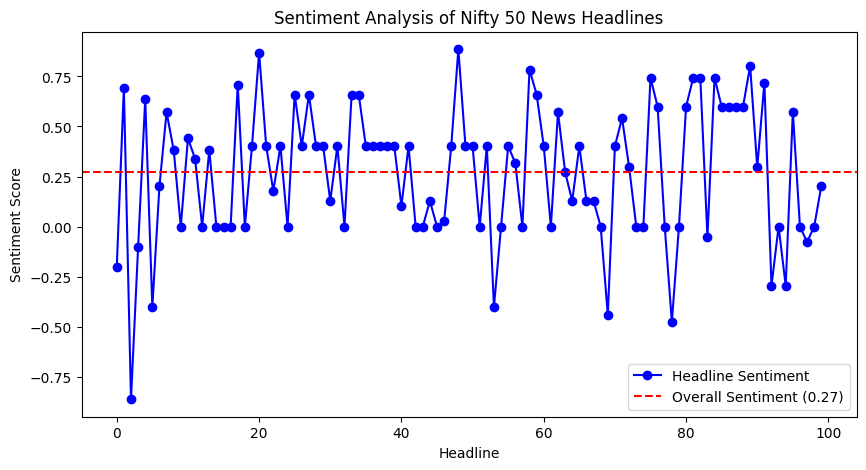

In [46]:
import matplotlib.pyplot as plt

def plot_sentiment(sentiments):
    plt.figure(figsize=(10, 5))
    plt.plot(sentiments, marker='o', color='b', label="Headline Sentiment")
    plt.axhline(overall_sentiment, color='r', linestyle='--', label=f'Overall Sentiment ({overall_sentiment:.2f})')
    plt.title("Sentiment Analysis of Nifty 50 News Headlines")
    plt.xlabel("Headline")
    plt.ylabel("Sentiment Score")
    plt.legend()
    plt.show()

plot_sentiment(sentiments)


In [47]:
import yfinance as yf
import datetime
import matplotlib.pyplot as plt


def fetch_nifty_data(start_date, end_date):
    nifty = yf.Ticker("^NSEI")  
    nifty_data = nifty.history(start=start_date, end=end_date)
    return nifty_data


end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=100)  # Last 30 days

# Fetch historical data
nifty_data = fetch_nifty_data(start_date, end_date)
nifty_closing_prices = nifty_data['Close']



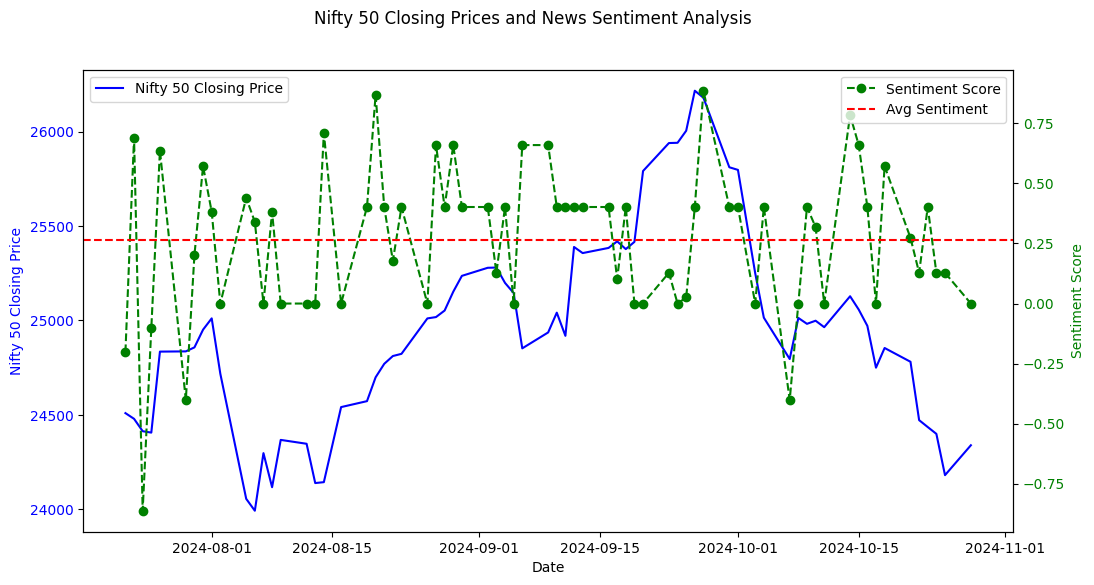

In [48]:

def plot_combined_chart(nifty_data, sentiments):
    
    if len(sentiments) > len(nifty_data):
        sentiments = sentiments[:len(nifty_data)]
    elif len(sentiments) < len(nifty_data):
        sentiments += [np.nan] * (len(nifty_data) - len(sentiments)) 

    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    
    ax1.plot(nifty_data.index, nifty_data['Close'], color='b', label="Nifty 50 Closing Price")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Nifty 50 Closing Price", color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    
    ax2 = ax1.twinx()
    ax2.plot(nifty_data.index, sentiments, color='g', label="Sentiment Score", linestyle='--', marker='o')
    ax2.set_ylabel("Sentiment Score", color='g')
    ax2.axhline(np.nanmean(sentiments), color='r', linestyle='--', label="Avg Sentiment")
    ax2.tick_params(axis='y', labelcolor='g')
    fig.suptitle("Nifty 50 Closing Prices and News Sentiment Analysis")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.show()

plot_combined_chart(nifty_data, sentiments)


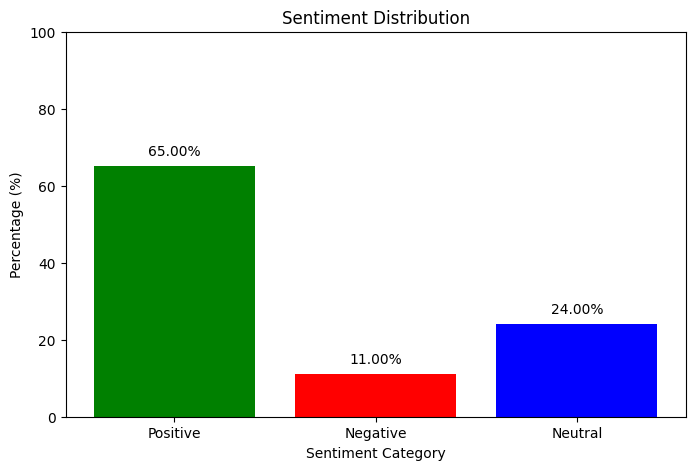

In [49]:
def classify_sentiments(sentiments):
    positive = sum(1 for score in sentiments if score > 0.05)  # Positive if score > 0.05
    negative = sum(1 for score in sentiments if score < -0.05)  # Negative if score < -0.05
    neutral = len(sentiments) - positive - negative  # Remaining are neutral

    return positive, negative, neutral

def plot_sentiment_distribution(sentiments):
    positive, negative, neutral = classify_sentiments(sentiments)
    
    
    total = len(sentiments)
    positive_percentage = (positive / total) * 100
    negative_percentage = (negative / total) * 100
    neutral_percentage = (neutral / total) * 100

    
    categories = ['Positive', 'Negative', 'Neutral']
    percentages = [positive_percentage, negative_percentage, neutral_percentage]

    
    plt.figure(figsize=(8, 5))
    plt.bar(categories, percentages, color=['green', 'red', 'blue'])
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)

    for i, percentage in enumerate(percentages):
        plt.text(i, percentage + 2, f'{percentage:.2f}%', ha='center', va='bottom')

    plt.show()

plot_sentiment_distribution(sentiments)
